# A Toxic Comment Identifier Application - Main Notebook
### DSC 478 - Winter 2023
### Project Type: App Dev
### Team Members: Jeff Bocek, Xuyang Ji, Anna-Lisa Vu


### Libraries

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
%matplotlib inline
from itertools import cycle
import seaborn as sns
from collections import defaultdict

#from sklearn's...
from sklearn.feature_extraction.text import CountVectorizer #Convert a collection of text documents to a matrix of token counts.
from sklearn.feature_extraction.text import TfidfTransformer #Transform a count matrix to a normalized tf or tf-idf representation
from sklearn.feature_extraction.text import TfidfVectorizer #Convert a collection of raw documents to a matrix of TF-IDF features
from sklearn.model_selection import train_test_split, GridSearchCV,ParameterGrid #Cross validation gird search and training and testing chunks
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.naive_bayes import ComplementNB
from sklearn.decomposition import TruncatedSVD,PCA #Dimension Reduction (LSA)
from sklearn.preprocessing import Normalizer, LabelBinarizer 
from sklearn import preprocessing, model_selection, metrics
from sklearn.ensemble import VotingClassifier #to create ensemble model
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import f1_score, mean_squared_error,accuracy_score,v_measure_score, silhouette_score,silhouette_samples
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import RocCurveDisplay, confusion_matrix, classification_report

### Data Preprocessing & Exploratory Analysis 

[Exploratory_Data_cleaning.ipynb](Toxic_App_Exploratory_Data_Cleaning.ipynb)

### Loading Cleaned and Processed Data

Loading subset of training data with percentage of original instances:  
1% of non-toxic comments: 1433  
10% of toxic comments: 1370 and  
100% of sever toxic comments: 1595

Loading subset of testing data with percentage of original instances:  
1% of non-toxic comments: 577  
10% of toxic comments: 572 and   
100% of sever toxic comments: 367

In [54]:
file_object = open('clean_data1.p', 'rb')
clean_data = pickle.load(file_object)
file_object.close()
train = clean_data[0]
test = clean_data[1]

In [55]:
#balanced training data
train_df_subset1 = train['comment_text']
train_lab_subset1 = train['toxicity_level']

#testing data
test_df_subset1 = test['comment_text']
test_lab_subset1 = test['toxicity_level']

Loading **uneven** subset of testing data with percentage of original instances:  
1% of non-toxic comments: 577  
20% of toxic comments: 1,144 and  
100% of sever toxic comments: 367

In [56]:
file_object = open('clean_data_unbalanced.p', 'rb')
clean_dataU = pickle.load(file_object)
file_object.close()
trainU = clean_dataU[0]
testU = clean_dataU[1]

In [57]:
#unbalanced training data
train_df_subsetU = trainU['comment_text']
train_lab_subsetU = trainU['toxicity_level']

#testing data
test_df_subsetU = testU['comment_text']
test_lab_subsetU = testU['toxicity_level']

## Data Transformation

### Term Frequencies

Simply put, the weights in the matrix represent the frequency of the term in a specific comment. The underlying concept is the higher the term frequency for a specific term in a comment, the more important it is for that comment. We use scikit-learn’s CountVectorizer(). Tuning occurred by adjusting the ‘max_df’ and ‘min_df’ which when building the vocabulary ignore terms that have a document frequency higher/lower respectively than the given threshold.

### TF*IDF

Term Frequency - Inverse Document Frequency assesses how important a term is within a comment relative to our collection of comments. It does this by vectorizing and scoring a term by multiplying the term’s Term Frequency (TF; number of times the term appears in the comment over the total number of terms in the comment)  by the Inverse Document Frequency (IDF; the log of; the total number of comments over the total number of comments which contain the specific term plus one). By using this formula we don’t place added importance on the super common words which overshadow less common words which can show more meaning to the comments. We used scikit-learn’s TfidfVectorizer() to transform our preprocessed collection of comments into a TF-IDF matrix. In aberration to the basic formula referenced above TfidfVectorizer() adds a “+1” to the numerator and denominator of the IDF score to prevent zero divisions when the term is not present to better represent the IDF scores for sparse matrices. We tuned this transformation by trying two methods of normalization; ‘l1’ and ‘l2’. ‘l1’  normalized by using the sum of the absolute values of the vector elements is 1 while ‘l2’ is the Euclidean norm and the sum of squares of vector elements is 1. For ‘l2’ the cosine similarity between two vectors is their dot product. As was the case with Term Frequency tuning, tuned by adjusting the ‘max_df’ and ‘min_df’ which when building the vocabulary ignore terms that have a document frequency higher/lower respectively than the given threshold. 

In [58]:
def TFIDF_func(data):
    vectorizer= TfidfVectorizer(smooth_idf=True, sublinear_tf=False, norm=None, 
                         analyzer='word')
    txt_fitted= vectorizer.fit(data)
    txt_tranformed = txt_fitted.transform(data) 
    X_tfidf= txt_tranformed.toarray()
    terms= txt_fitted.get_feature_names_out()
    return X_tfidf, terms

trainX_tfidf, terms_train= TFIDF_func(train_df_subset1)
testX_tfidf, terms_test= TFIDF_func(test_df_subset1)
trainXU_tfidf, termsU_train= TFIDF_func(train_df_subsetU)
testXU_tfidf, termsU_test= TFIDF_func(test_df_subsetU)

### Doc2Vec
Doc2Vec is a natural language processing technique to transform a set of documents into a list of vectors.  It is closely related to Word2Vec and is considered a more generalized form of it.  In Word2Vec, the algorithm looks at the context of each word and surrounding words. It assigns a numerical value to the word which represents the meaning of the word given its context.  For example, the chances of “Paris” and “France” being in the same sentence are higher than “Paris” and “power”.  Word2Vec takes this into consideration when creating the numerical value for each word. This example was taken from this [article](https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e).

Doc2Vec has generalized this technique.  Instead of having a numeric representation for the words, you can achieve a numeric representation for a document as a whole.  We thought it would be a good exercise to use this data transformation technique in our project.  Each comment can be like a document.  To create the Doc2Vec vectors, we used the doc2Vec library package from the gensim.models library.  We ran this against the train and test data and fed that into our models.


In the notebook below (which is in the same folder) are central methods we created so that we can get a doc2vec vector for the train and test data.  Using these methods each team member was able to feed a doc2vec transformed data set into the models.  Analysis and evaluations of our the models performed with the data set is explained in the upcoming sections.

[Doc2Vec Notebook](Toxic_App_Doc2Vec.ipynb)
(If the link doesn't work, please navigate to Toxic_App_Doc2Vec.ipynb in the same folder as this notebook)

We ran the notebook in order to use common methods to infer doc2vec vectors.

In [59]:
from gensim.models import doc2vec
%run Toxic_App_Doc2Vec.ipynb

Infer vectors for a balanced data set.

In [60]:
# Balanced training set
# Final set of parameters to use: 'dm': 0, 'vector_size': 1000, 'window': 5, 'hs': 1, 'negative': 0
d2v_model = doc2vec.Doc2Vec(dm = 1, vector_size = 1000, window=5, min_count = 1, hs=1, epochs = 10)
train_vectors1 = get_doc2vec_vectors(d2v_model, train_df_subset1)
tokenized_test_comments = tokenize_comments(test_df_subset1)
test_vectors1 = infer_vectors(d2v_model, tokenized_test_comments, "")

Infer vectors for an unbalanced data set.

In [61]:
# Unbalanced training set
#Final set of parameters to use: 'dm': 0, 'vector_size': 1000, 'window': 5, 'hs': 1, 'negative': 0
d2v_model = doc2vec.Doc2Vec(dm = 1, vector_size = 1000, window = 5, min_count = 1, hs=1, epochs = 10)
train_vectorsU = get_doc2vec_vectors(d2v_model, train_df_subsetU)
tokenized_test_comments = tokenize_comments(test_df_subsetU)
test_vectorsU = infer_vectors(d2v_model, tokenized_test_comments, "")

### Data Dictionary for Models
Finally, we store the data sets from our transformations so that we can access them during model creation and evaluation.

In [62]:
subsets = {
    # [X_train, y_train, X_test, y_test]
    'balanced': [train_df_subset1, train_lab_subset1, test_df_subset1, test_lab_subset1],
        # balanced training data with ratios 0.01, 0.10, 1.0
    'balanced_TDIDF': [trainX_tfidf, terms_train, train_lab_subset1, testX_tfidf, terms_test, test_lab_subset1],
    'balanced_D2V': [train_vectors1, train_lab_subset1, test_vectors1, test_lab_subset1],
   
    'unbalanced': [train_df_subsetU, train_lab_subsetU, test_df_subsetU, test_lab_subsetU],
        # unbalanced training data with ratios 0.01, 0.20, 1.0
    'unbalanced_TFIDF':[trainXU_tfidf, termsU_train,train_lab_subsetU, testXU_tfidf, termsU_test, test_lab_subsetU],
    'unbalanced_D2V': [train_vectorsU, train_lab_subsetU, test_vectorsU, test_lab_subsetU],
}

### LSA for Dimension Reduction 

In [109]:
# LSA and Plot for Cumulative_explained_variance vs n_componenets
def LSA(X, list_comp): 
    EVar=[] 
    for n_comp in list_comp:
        lsa= make_pipeline(TruncatedSVD(n_components=n_comp), 
                           Normalizer(copy=False))
        lsa.fit(X)
        explainedVar = lsa[0].explained_variance_ratio_.sum()
        EVar.append(explainedVar)
        print("Number of components = %r and explained variance = %r"%(n_comp,explainedVar))
    plt.plot(list_comp,EVar, linewidth=2)
    plt.xlabel('n_components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title("Cumulative Explained Variance VS N_components")
    plt.show()

Number of components = 118 and explained variance = 0.9868841454999873
Number of components = 108 and explained variance = 0.9847084341860368
Number of components = 98 and explained variance = 0.9801371052581006
Number of components = 88 and explained variance = 0.9717037675803458
Number of components = 78 and explained variance = 0.9570933412127928
Number of components = 68 and explained variance = 0.9379348348934191
Number of components = 58 and explained variance = 0.9091723112410673
Number of components = 48 and explained variance = 0.8685605691048237
Number of components = 38 and explained variance = 0.7968180260647659
Number of components = 28 and explained variance = 0.6993928484991422
Number of components = 18 and explained variance = 0.5679199017109228
Number of components = 8 and explained variance = 0.3602015546951982


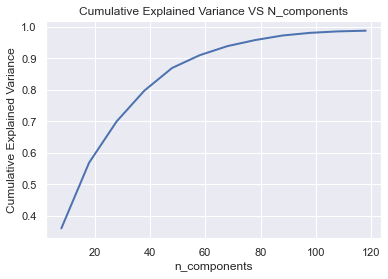

In [110]:
step=10
column= trainX_tfidf.shape[1] 
LSA(trainX_tfidf,range(column-(1470*step),0,-step))

## Supervised Modeling & Hyperparameter Tuning

In [63]:
#import tuning and model evaluation functions
%run Toxic_App_Tuning_&_Evaluation_funcs.ipynb
pipe_param_dict = {}

### Logistic Regression as the Benchmark

The baseline model is a Logistic Regression model fit to tf-idf vectorized comment text with using only words for tokens, with the target value being toxicity_level. 


In [101]:
### Gradiant Descent/Logistic Regression as the Baseline Model 
skf= StratifiedKFold(n_splits=5,shuffle=True,random_state=961)
target= np.array(train_lab_subset1)
w=[]
#loop through the value for svd dimension parameter
for n in range(116,106,-1): #negative step to let range decrease from start
    log=[]
    for train_index, test_index in skf.split(trainX_tfidf,target):
        xTrain, xTest= trainX_tfidf[train_index,:],trainX_tfidf[test_index,:]
        yTrain,yTest= target[train_index],target[test_index]
        lsa= make_pipeline(TruncatedSVD(n_components=n, random_state=961), Normalizer(copy=False))
        xTrain_lsa= lsa.fit_transform(xTrain)
        xTest_lsa= lsa.transform(xTest)    
        explainedVar = lsa[0].explained_variance_ratio_.sum()
        sdg_params = { 
            'loss': ['log'], 
            'penalty': ['l2','elasticnet'],
            "l1_ratio" : np.arange(0,1,0.1),
            'n_jobs': [-1]
            }
        model= SGDClassifier(max_iter= 3000,random_state=961)
        grid= GridSearchCV(model, param_grid=sdg_params,cv=5)
        grid.fit(xTrain_lsa,yTrain)
        #model= LogisticRegression(solver='lbfgs',multi_class="multinomial").fit(xTrain_lsa,yTrain)

        BModel= SGDClassifier(**grid.best_params_, max_iter= 3000,random_state=961)
        BModel.fit(xTrain_lsa,yTrain)

        f1Train= f1_score(yTrain,BModel.predict(xTrain_lsa),average='weighted')
        f1Test= f1_score(yTest,BModel.predict(xTest_lsa),average='weighted') 
        AccTest= accuracy_score(yTest,BModel.predict(xTest_lsa))
        log.append([f1Train,f1Test,AccTest])
    print("For n_component= %r with explained variance = %r,the best parameters are: %r"%(n, explainedVar,grid.best_params_))
    
    mean= np.mean(log,axis=0)
    F1_train= mean[0]
    F1_test= mean[1]
    Accu_Test= mean[2]

    w.append([n,F1_train, F1_test, Accu_Test])  
svd_dm= pd.DataFrame(w,columns=['N',"F1_Train","F1_Test","Accuracy _Test"])

For n_component= 116 with explained variance = 0.9857100780358736,the best parameters are: {'l1_ratio': 0.9, 'loss': 'log', 'n_jobs': -1, 'penalty': 'elasticnet'}
For n_component= 115 with explained variance = 0.9856189255674715,the best parameters are: {'l1_ratio': 0.0, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l2'}
For n_component= 114 with explained variance = 0.9855248872873983,the best parameters are: {'l1_ratio': 0.9, 'loss': 'log', 'n_jobs': -1, 'penalty': 'elasticnet'}
For n_component= 113 with explained variance = 0.9854274266091319,the best parameters are: {'l1_ratio': 0.0, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l2'}
For n_component= 112 with explained variance = 0.9853309733918915,the best parameters are: {'l1_ratio': 0.8, 'loss': 'log', 'n_jobs': -1, 'penalty': 'elasticnet'}
For n_component= 111 with explained variance = 0.9852297890998716,the best parameters are: {'l1_ratio': 0.9, 'loss': 'log', 'n_jobs': -1, 'penalty': 'elasticnet'}
For n_component= 110 with explained va

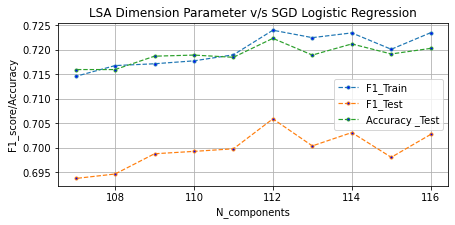

,N,F1_Train,F1_Test,Accuracy _Test
4,112,0.72403,0.705946,0.72237


In [102]:
kwargs = dict (linestyle='dashed', linewidth=1.2,marker='o',
               markerfacecolor='blue', markersize=3)
line_plot= svd_dm.plot(x="N",figsize=(7,3),**kwargs)
line_plot.set_title('LSA Dimension Parameter v/s SGD Logistic Regression')
line_plot.grid()
line_plot.set_xlabel('N_components')
line_plot.set_ylabel('F1_score/Accuracy')
plt.show()
bestN= svd_dm[svd_dm.index==svd_dm['F1_Test'].argmax()]
bestN

### Unsupervised Model to ensure data quality - K-Means Clustering

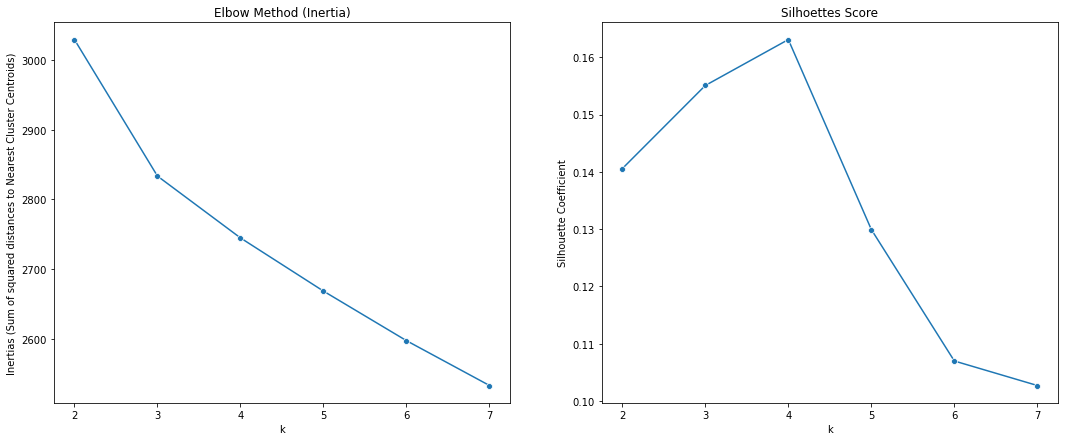

In [103]:
### KMean
lsa= make_pipeline(TruncatedSVD(n_components=112, random_state=961), Normalizer(copy=False))
XLSA= lsa.fit_transform(trainX_tfidf)
log = [] 
k_range = range(2,8) # Range of k values

for k in k_range:
    kmean = KMeans(n_clusters = k, random_state=961)
    clusterLabel = kmean.fit_predict(XLSA)
    inertia= kmean.inertia_
    centroids= kmean.cluster_centers_
    if True: # Generate Silhoettes Score
        silhoettes_avg = silhouette_score(XLSA, clusterLabel)
        log.append([k, inertia, silhoettes_avg])
        continue
    log.append([k, inertia])

plot_df = pd.DataFrame(
    log, columns = [
        'k', 'Inertias (Sum of squared distances to Nearest Cluster Centroids)', 'Silhouette Coefficient'
        ]
    )
fig, axes = plt.subplots(1,2, figsize=(18,7))
sns.lineplot(
    x='k', y='Inertias (Sum of squared distances to Nearest Cluster Centroids)', 
    data = plot_df, marker= 'o', ax = axes[0])
axes[0].set_title("Elbow Method (Inertia)")
sns.lineplot(x='k', y='Silhouette Coefficient', data=plot_df, marker='o', ax = axes[1])
axes[1].set_title("Silhoettes Score")
plt.show()

In [104]:
def silhouette_analysis_with_tsvd(n_clusters,X):
    
    # K-Mean Clustering
    kmean = KMeans(n_clusters = n_clusters, random_state=961)
    clusterLabel = kmean.fit_predict(X)
    centroids= kmean.cluster_centers_

    # Compute Individual Silhoette Score
    silhoettes_avg = silhouette_score(X, clusterLabel)

    # Compute Average Silhoette Score
    sample_silhouette_values = silhouette_samples(X, clusterLabel)
     # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ################################### Silhouette Plot #############################################
 
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_xlim([-0.1, 1])
    y_lower = 10

    # Assign colours for different cluster
    for i in range(n_clusters):
         # Aggregate the silhouette scores for samples belonging to
         # cluster i, and sort them
         ith_cluster_silhouette_values = sample_silhouette_values[clusterLabel == i]
         ith_cluster_silhouette_values.sort()
         size_cluster_i = ith_cluster_silhouette_values.shape[0]
         y_upper = y_lower + size_cluster_i
         color = cm.nipy_spectral(float(i) / n_clusters)
         ax1.fill_betweenx(np.arange(y_lower, y_upper),
                           0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.7)
         
         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
         y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette Plot for Clusters.")
    ax1.set_xlabel("Silhouette Coefficient Values")
    ax1.set_ylabel("Cluster Label")
    # avg sil score 
    ax1.axvline(x=silhoettes_avg, color="red", linestyle="--")
    ax1.set_yticks([]) 
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8])

    ################################### SVD Plot #############################################
 
    # Compute tsvd with only First 2 Number of Component
    tsvd2 = TruncatedSVD(n_components=2)
    sample2 = tsvd2.fit_transform(X)

    ##Getting diff color for diff cluster 
    colors = cm.nipy_spectral(clusterLabel.astype(float) / n_clusters)
    ax2.scatter(sample2[:,0], sample2[:,1], marker='.', s=70, lw=0, alpha=1,
            c=colors, edgecolor='k')

    centers = centroids.dot(tsvd2.components_.T) # Cluster Positions after transformation 
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                 c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of TSVD with total explained variance of {:.2f}%.".format(tsvd2.explained_variance_ratio_.sum()*100))
    ax2.set_xlabel("Feature space for the 1st component")
    ax2.set_ylabel("Feature space for the 2nd component")
    plt.suptitle(("Silhouette analysis for KMeans clustering on Toxic Comment Dataset"
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

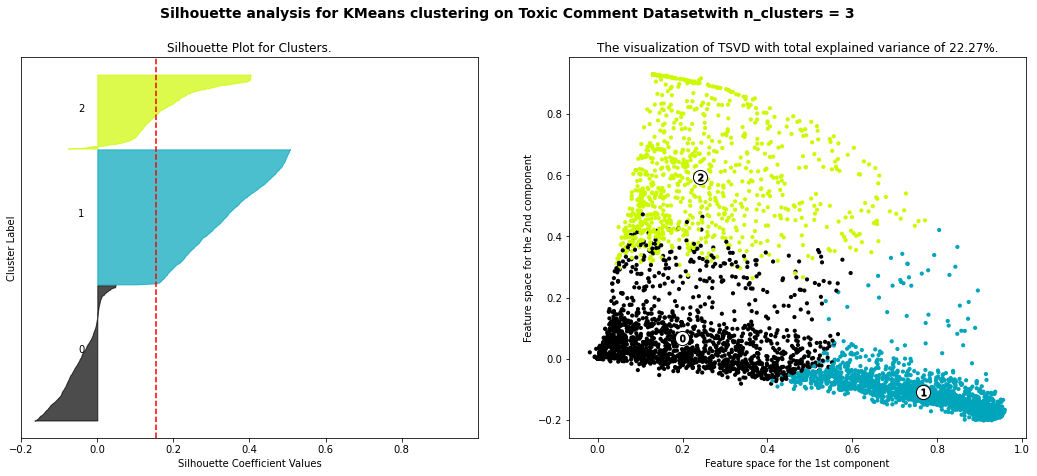

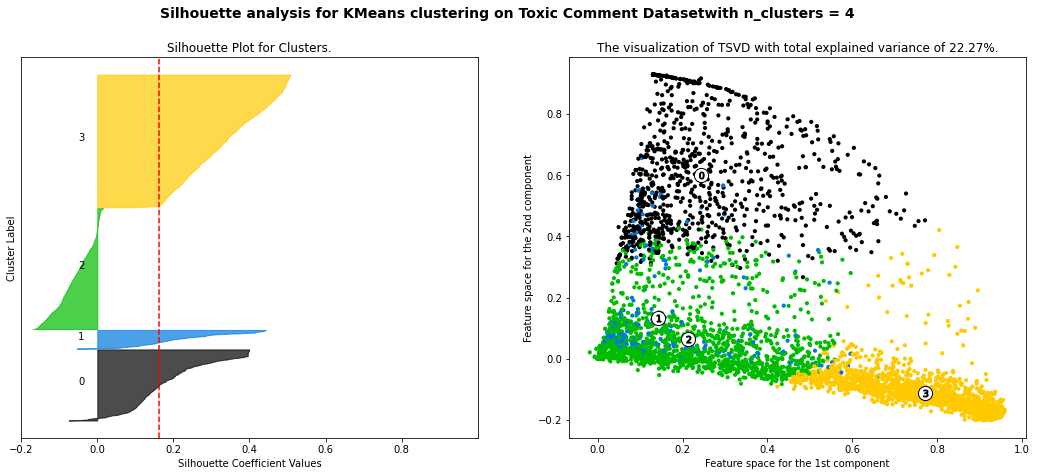

In [105]:
for i, k in enumerate(range(3,5)): # Analyse k = (3,4)
    silhouette_analysis_with_tsvd(n_clusters = k, X = XLSA)
    plt.show()

In [106]:
#go with k=3
kmean3 = KMeans(n_clusters = 3, random_state=961)
clusterLabel3 = kmean3.fit_predict(XLSA)
centroids3= kmean3.cluster_centers_

In [107]:
original_space_centroids = lsa[0].inverse_transform(kmean3.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
labels = train.toxicity_level
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms_train[ind]} ", end="")
    print()

Cluster 0: suck go bitch youre shit wikipedia article get asshole stupid 
Cluster 1: article page use like people source one tag copyright make 
Cluster 2: fuck go shit bitch youre asshole cunt faggot article wikipedia 


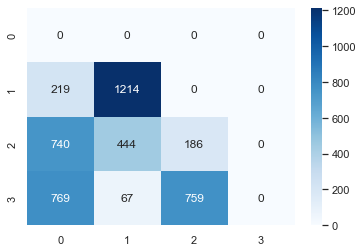

In [108]:
from sklearn.metrics import confusion_matrix
confuM= confusion_matrix(labels,kmean3.labels_)
sns.set()
ax=sns.heatmap(confuM,annot=True,fmt="d",cmap="Blues")

In [65]:
# Logistic Pipeline

LSA112= make_pipeline(TruncatedSVD(n_components=112, random_state=961), Normalizer(copy=False))

pipe_logistic = Pipeline(
    [
        ('token_value', 'passthrough'),
        ('reduce_dim', 'passthrough'),
        ('clf', SGDClassifier(max_iter= 8000,random_state=961))
    ]
)

# Logistic pipeline with Doc2Vec
pipe_D2V_logistic = Pipeline(
    [
        ('reduce_dim', 'passthrough'),
        ('clf', SGDClassifier(max_iter= 8000,random_state=961))
    ]
)

Logistic_params =[
    {
        'token_value': [CountVectorizer(), TfidfVectorizer()],
        'token_value__min_df': [1, 3, 10],
        'token_value__max_df': [0.6,0.8,0.9],
        'reduce_dim': [Normalizer(copy=False)],
        'clf__loss': ['log'],
        'clf__penalty':['elasticnet'],
        'clf__l1_ratio': [0.9],
        'clf__n_jobs':[-1]
    },
            
    {
        'token_value': [CountVectorizer(), TfidfVectorizer()],
        'token_value__min_df': [1,3,10,],
        'token_value__max_df': [0.6,0.8,0.9],
        'reduce_dim': [LSA112],
        'clf__loss': ['log'],
        'clf__penalty':['elasticnet'],
        'clf__l1_ratio': [0.9],
        'clf__n_jobs':[-1]
    }
]
#Doc2Vec parameter dictionary for Logistic pipeline
D2V_logistic_params =[
    {
        'reduce_dim': ['passthrough'],
        'clf__loss': ['log'],
        'clf__penalty':['elasticnet'],
        'clf__l1_ratio': [0.9],
        'clf__n_jobs':[-1]
    },
    {
        'reduce_dim': [LSA112],
        'clf__loss': ['log'],
        'clf__penalty':['elasticnet'],
        'clf__l1_ratio': [0.9],
        'clf__n_jobs':[-1]
    }
]

In [66]:
#pipeline with parameter dictionary
pipe_param_dict['Logistic_pipeline'] = [pipe_logistic, Logistic_params]
pipe_param_dict['Doc2Vec_logistic_pipeline']= [pipe_D2V_logistic, D2V_logistic_params]

In [67]:
Logistic_best= run_on_subset(pipe_param_dict['Logistic_pipeline'],subsets['balanced'])

Pipeline = Pipeline(steps=[('token_value', 'passthrough'), ('reduce_dim', 'passthrough'),
                ('clf', SGDClassifier(max_iter=8000, random_state=961))])
Best parameters = 
clf__l1_ratio: 0.9
clf__loss: log
clf__n_jobs: -1
clf__penalty: elasticnet
reduce_dim: Pipeline(steps=[('truncatedsvd',
                 TruncatedSVD(n_components=112, random_state=961)),
                ('normalizer', Normalizer(copy=False))])
token_value: TfidfVectorizer(max_df=0.6, min_df=3)
token_value__max_df: 0.6
token_value__min_df: 3
Accuracy on train set: 0.763
Accuracy on test set: 0.728


In [68]:
Doc2Vec_logstic_best = run_on_subset(pipe_param_dict['Doc2Vec_logistic_pipeline'], subsets['balanced_D2V'])

Pipeline = Pipeline(steps=[('reduce_dim', 'passthrough'),
                ('clf', SGDClassifier(max_iter=8000, random_state=961))])
Best parameters = 
clf__l1_ratio: 0.9
clf__loss: log
clf__n_jobs: -1
clf__penalty: elasticnet
reduce_dim: Pipeline(steps=[('truncatedsvd',
                 TruncatedSVD(n_components=112, random_state=961)),
                ('normalizer', Normalizer(copy=False))])
Accuracy on train set: 0.654
Accuracy on test set: 0.641


### Nearest Centroid

In the Nearest Centroid classifier, a mean centroid is calculated from the training set for each class. The model uses the label of the closest centroid to the test instance to classify the test instance.

Below, we use the NearestCentroid implementation from the sklean library for this model.  There are 2 different pipelines, one that uses a CountVectorizer (term counts) and a TFIDVectorizer (TF*IDF) as well as one that will use a Doc2Vec vector for data transformation.  These pipelines are passed into a shared method where we are running all our pipelines.  The best parameters are printed after running the method.

In [69]:
# Rocchio Pipeline
pipe_Rocchio = Pipeline(
    [
        ('token_value', 'passthrough'),
        ('reduce_dim', 'passthrough'),
        ('clf', NearestCentroid())
    ]
)

# Rocchio pipeline with Doc2Vec
pipe_D2V_Rocchio = Pipeline(
    [
        ('reduce_dim', 'passthrough'),
        ('clf', NearestCentroid())
    ]
)

For hyperparameter tuning, I had to split out the tuning of the full feature set vs. the truncated feature set (via SVD).  This was so that my pipelines could finish in a reasonable time.  I attempted to try tuning with the shrink_threshold parameter which is included with the Nearest Centroid classifier; however, I kept getting an error stating "threshold shrinking not supported for sparse input".  Therefore, I had to leave that out for tuning.

In [70]:
#Hyperparameter tuning

#Token 
min_DF = [1, 3, 10]
max_DF = [0.6, 0.8, 0.9]
#norm = ['l1','l2']


#Classifer 
metric = ['euclidean', 'cosine']
#shrink_threshold = ['None', 0.2]

#Parameter dictionary for Rocchio Pipeline
Rocchio_params =[
    {
        'token_value': [CountVectorizer(), TfidfVectorizer()],
        'token_value__min_df': min_DF,
        'token_value__max_df': max_DF,
        'reduce_dim': ['passthrough'],
        'clf__metric': metric
    }
]

Rocchio_params_svd =[
    {
        'token_value': [CountVectorizer(), TfidfVectorizer()],
        'token_value__min_df': min_DF,
        'token_value__max_df': max_DF,
        'reduce_dim': [LSA112],
        'clf__metric': metric
    }
]


#Doc2Vec parameter dictionary for Rocchio pipeline
#We will pass in the data directly instead of going through a
#CountVectorizer or TfidVectorizer
D2V_Rocchio_params =[
    {
        'reduce_dim': ['passthrough'],
        'clf__metric': metric,
    },
     {
        'reduce_dim': [LSA112],
        'clf__metric': metric
    }
]

Below we create the dictionaries to pass into our custom run and evaluation function.

In [71]:
#pipeline with parameter dictionary
pipe_param_dict['Rocchio_pipeline'] = [pipe_Rocchio, Rocchio_params]
pipe_param_dict['Rocchio_pipeline_svd'] = [pipe_Rocchio, Rocchio_params_svd]
pipe_param_dict['Doc2Vec_Rocchio_pipeline']= [pipe_D2V_Rocchio, D2V_Rocchio_params]

#### Tune Nearest Centroid model using Count and Term Vectorizer via GridSearchCV() for a Balanced Data Set
(Note there are user warnings being thrown since we are passing in a cosine distance metric when evaluate the NearestCentroid.These can be ignored for now.)

In [72]:
rocchio_best = run_on_subset(pipe_param_dict['Rocchio_pipeline'], subsets['balanced'])

c:\Users\jjbocek\anaconda3\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:164: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(


Pipeline = Pipeline(steps=[('token_value', 'passthrough'), ('reduce_dim', 'passthrough'),
                ('clf', NearestCentroid())])
Best parameters = 
clf__metric: cosine
reduce_dim: passthrough
token_value: TfidfVectorizer(max_df=0.6)
token_value__max_df: 0.6
token_value__min_df: 1
Accuracy on train set: 0.778
Accuracy on test set: 0.698


In [73]:
rocchio_best_svd = run_on_subset(pipe_param_dict['Rocchio_pipeline_svd'], subsets['balanced'])

c:\Users\jjbocek\anaconda3\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:164: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(


Pipeline = Pipeline(steps=[('token_value', 'passthrough'), ('reduce_dim', 'passthrough'),
                ('clf', NearestCentroid())])
Best parameters = 
clf__metric: cosine
reduce_dim: Pipeline(steps=[('truncatedsvd',
                 TruncatedSVD(n_components=112, random_state=961)),
                ('normalizer', Normalizer(copy=False))])
token_value: TfidfVectorizer(max_df=0.6, min_df=3)
token_value__max_df: 0.6
token_value__min_df: 3
Accuracy on train set: 0.726
Accuracy on test set: 0.707


Based on the above, our method found that the best parameters for the Nearest Centroid model for both a full and truncated balanced data set are the following:
    * metric: cosine
    * data transformation: TfidfVectorizer using a max of 0.6 and a min of 1 (Note: when using float in these values, it is taken as a proportion instead of the value itself)

#### Tune Nearest Centroid model with Doc2Vec via GridSearchCV() for a Balanced Data Set
(Note there are user warnings being thrown since we are passing in a cosine distance metric when evaluate the NearestCentroid.These can be ignored for now.)

In [74]:
doc2Vec_rocchio_best = run_on_subset(pipe_param_dict['Doc2Vec_Rocchio_pipeline'], subsets['balanced_D2V'])

Pipeline = Pipeline(steps=[('reduce_dim', 'passthrough'), ('clf', NearestCentroid())])
Best parameters = 
clf__metric: cosine
reduce_dim: Pipeline(steps=[('truncatedsvd',
                 TruncatedSVD(n_components=112, random_state=961)),
                ('normalizer', Normalizer(copy=False))])
Accuracy on train set: 0.611
Accuracy on test set: 0.573


c:\Users\jjbocek\anaconda3\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:164: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(


Based on the above, our method found that the best parameters for the Nearest Centroid model for both a full and truncated Doc2Vec data set are the following:
    * metric: cosine
    * data transformation: Doc2Vec
    * reduction: passthrough (non-svd)

#### Conclusion

For all our evaluations, the settings below were chosen as the best.  Therefore, when we evaluate this model in the next section we will be using these parameters:
    * metric: cosine
    * For TfidfVectorizer using a max of 0.6 and a min of 1 (Note: when using float in these values, it is taken as a proportion instead of the value itself)
    * For Doc2Vec, using a non-reduced data set



### Naive Bayes 

The Naive Bayes model uses the probabilities of the features and vectors to predict the class of our comments. The NB assumes independence between the features and a normal distribution. NB was chosen as it works well with text classification with a multiclass problem. We included the smoothing parameter in our tuning to account for small samples which use Laplace smoothing to correct for zero frequency issues. Truncated SVD (feature reduction) and using Doc2Vec were unable to be used as NB is incompatible with passing negative values. If we had more time we could have explored the correlations between the terms to try and reduce our features so we reduce the inflating of importance. While our dataset is not severely unbalanced we used Complement Naive Bayes (CNB) as it performs better on text classification than the standard Multinomial Naive Bayes. CNB uses the complement of each class to compute the model’s weights. It applies a second normalization to address the tendency for longer documents to dominate parameter estimates in MNB. 

In [75]:
# pipeline using term frequency and complimentary Naive Bayes
pipe_CountVect_CompNB = Pipeline([
    ('count', CountVectorizer()),
    ('clf', ComplementNB())
    ])

# pipeline using Tfidf and complimentary Naive Bayes
pipe_TfidfVect_CompNB = Pipeline([
    ('vect', TfidfVectorizer()),
    ("clf", ComplementNB())
    ])

# pipeline using Doc2Vec and complimentary Naive Bayes is incompatible as passes negative values

In [76]:
# Hyperparameter tunning

# parameters for CountVectorizer() (see above Term Frequency)
countvect_params = {
    'count__min_df': [1, 3, 10], 
    'count__max_df': [0.6, 0.8, 0.9]
    
}

# parameters for TfidfVectorizer() (see above Tfidf)
vectorizer_params = {
    'vect__min_df': [1, 3, 10], 
    'vect__max_df': [0.6, 0.8, 0.9],
    'vect__norm': ['l1','l2']
}

# parameters for Complimentary Naive Bayes()
compNB_params = {
    'clf__alpha' : [0, 1]       #smoothing parameter to reduce zero frequency effects if alpha = 1
}

In [77]:
pipe_param_dict['CountVect_CompNB'] = [pipe_CountVect_CompNB, countvect_params]
pipe_param_dict['TfidfVect_CompNB'] = [pipe_TfidfVect_CompNB, vectorizer_params]

Tune Naive Bayes model with Term Frequencies via GridSearchCV()

In [78]:
CV_NB_best = run_on_subset(pipe_param_dict['CountVect_CompNB'], subsets['balanced'])

Pipeline = Pipeline(steps=[('count', CountVectorizer()), ('clf', ComplementNB())])
Best parameters = 
count__max_df: 0.6
count__min_df: 1
Accuracy on train set: 0.821
Accuracy on test set: 0.617


In [ ]:
#explanation of best parameters

Tune Naive Bayes model with TFIDF via GridSearchCV()

In [79]:
Tfidf_NB_best = run_on_subset(pipe_param_dict['TfidfVect_CompNB'], subsets['balanced'])

Pipeline = Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', ComplementNB())])
Best parameters = 
vect__max_df: 0.6
vect__min_df: 3
vect__norm: l1
Accuracy on train set: 0.790
Accuracy on test set: 0.640


In [ ]:
#explanation of best parameters

### KNN

The K Nearest Neighbors model depends on a distance or similarity function to compare how far apart instances (data points) are away from each other. In classification, for a given number of points, the majority label of these “nearest neighbors” is assigned to our point in question. To tune our KNN model we examined three parameters. The first was the number of neighbors (k). A larger k should reduce the effects of noise but will make the classification boundary fuzzier. A smaller k could overfit the model. The second parameter used was the type of distance function used to measure between the points. We tried either the cosine distance which measures the angle between the two vectors of the points and the minkowski distance with p= 2 which is the euclidian distance function (pythagorean distance). Typically when dealing with sparse data (text data) the cosine distance helps the model to perform better. The last parameter tuned was the weights function used in the prediction of points using the model. We examined uniform weights (all the neighbors are weighed the same) versus distance weights which the closer neighbors will have a stronger impact than the ones further away.  

*Best tuned model*:  We used scikit-learn’s GridSearchCV() to search which of these parameters would produce the best model using stratified five-fold cross validation which preserves the percentage of samples for each class. Our best model used the Term Frequency vectors (not Tfidf) with a , no dimensionality reduction (vs, SVD), the cosine distance, ten nearest neighbors, and the neighbor weights were uniform. The model using Doc2Vec instead of Term Frequency had the same parameters. 

In [80]:
# KNN Pipeline
pipe_KNN = Pipeline(
    [
        ('token_value', 'passthrough'),         #use Term Frequency or Tfidf
        ('reduce_dim', 'passthrough'),          # use truncated SVD or none for dimension reduction
        ('clf', KNeighborsClassifier())
    ]
)

# Doc2Vec KNN Pipeline
pipe_D2V_KNN = Pipeline(
    [
        ('reduce_dim', 'passthrough'),          # use truncated SVD or none for dimension reduction
        ('clf', KNeighborsClassifier())
    ]
)

In [81]:
#Hyperparameter tunning

#Token parameters (see Term Frequency above)
min_DF = [1, 3, 10]
max_DF = [0.6, 0.8, 0.9]

#Dimensionality Reduction parameters
#LSA109= make_pipeline(TruncatedSVD(n_components=109), Normalizer(copy=False))

#Classifer parameters
n_neighbors = [5, 10]
weights = ['uniform', 'distance']
metric = ['minkowski', 'cosine']

#Parameter dictionary for KNN Pipeline
KNN_params =[
    {
        'token_value': [CountVectorizer(), TfidfVectorizer()],
        'token_value__min_df': min_DF,
        'token_value__max_df': max_DF,
        'reduce_dim': ['passthrough'],
        'clf__n_neighbors': n_neighbors,
        'clf__weights': weights,
        'clf__metric': metric
    },
    {
        'token_value': [CountVectorizer(), TfidfVectorizer()],
        'token_value__min_df': min_DF,
        'token_value__max_df': max_DF,
        'reduce_dim': [LSA112],                                     
        'clf__n_neighbors': n_neighbors,
        'clf__weights': weights,
        'clf__metric': metric
    }
]

#Doc2Vec parameter dictionary for KNN pipeline
D2V_KNN_params =[
    {
        'reduce_dim': ['passthrough'],
        'clf__n_neighbors': n_neighbors
    },
    {
        'reduce_dim': [LSA112],
        'clf__n_neighbors': n_neighbors
    }
]

In [82]:
#pipeline with parameter dictionary
pipe_param_dict['KNN_pipeline'] = [pipe_KNN, KNN_params]
pipe_param_dict['Doc2Vec_KNN_pipeline']= [pipe_D2V_KNN, D2V_KNN_params]

Tune KNN model without Doc2Vec via GridSearchCV()

In [83]:
KNN_best = run_on_subset(pipe_param_dict['KNN_pipeline'], subsets['balanced'])

Pipeline = Pipeline(steps=[('token_value', 'passthrough'), ('reduce_dim', 'passthrough'),
                ('clf', KNeighborsClassifier())])
Best parameters = 
clf__metric: cosine
clf__n_neighbors: 10
clf__weights: uniform
reduce_dim: passthrough
token_value: CountVectorizer(max_df=0.6, min_df=10)
token_value__max_df: 0.6
token_value__min_df: 10
Accuracy on train set: 0.738
Accuracy on test set: 0.609


In [ ]:
#explanation of best parameters

Tune KNN model with Doc2Vec via GridSearchCV()

In [84]:
Doc2Vec_KNN_best = run_on_subset(pipe_param_dict['Doc2Vec_KNN_pipeline'], subsets['balanced_D2V'])
# function from Toxic_App_Tuning_&_Evaluation_funcs.ipynb

Pipeline = Pipeline(steps=[('reduce_dim', 'passthrough'), ('clf', KNeighborsClassifier())])
Best parameters = 
clf__n_neighbors: 10
reduce_dim: Pipeline(steps=[('truncatedsvd',
                 TruncatedSVD(n_components=112, random_state=961)),
                ('normalizer', Normalizer(copy=False))])
Accuracy on train set: 0.655
Accuracy on test set: 0.481


In [ ]:
#explanation of best parameters

## Evaluation of Models - Model Comparisons

For those models where appropriate we evaluated the confusion matrix, accuracy, and ROC AUC score for each model. As part of the confusion matrix evaluation we looked at the precision, recall, and F1 scores.

### Gradiant Descent/Logistic Regression (Xuyang)

              precision    recall  f1-score   support

   non-toxic       0.84      0.84      0.84       577
       toxic       0.69      0.55      0.61       572
severe_toxic       0.63      0.83      0.72       367

    accuracy                           0.73      1516
   macro avg       0.72      0.74      0.72      1516
weighted avg       0.73      0.73      0.72      1516



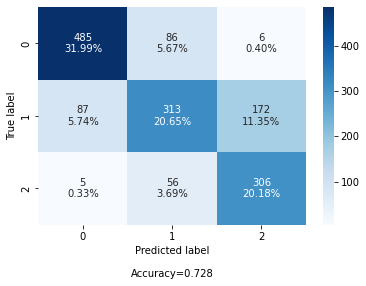

In [85]:
analysis_no_pred_prob(subsets['balanced'], target_names, Logistic_best)

              precision    recall  f1-score   support

   non-toxic       0.75      0.76      0.76       577
       toxic       0.57      0.50      0.53       572
severe_toxic       0.57      0.66      0.61       367

    accuracy                           0.64      1516
   macro avg       0.63      0.64      0.64      1516
weighted avg       0.64      0.64      0.64      1516



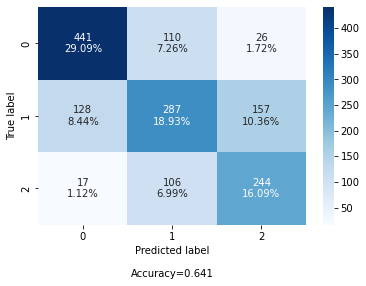

In [86]:
analysis_no_pred_prob(subsets['balanced_D2V'], target_names, Doc2Vec_logstic_best)

### Rocchio

c:\Users\jjbocek\anaconda3\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:164: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(


              precision    recall  f1-score   support

   non-toxic       0.83      0.80      0.81       577
       toxic       0.63      0.56      0.59       572
severe_toxic       0.62      0.75      0.68       367

    accuracy                           0.70      1516
   macro avg       0.69      0.70      0.69      1516
weighted avg       0.70      0.70      0.70      1516



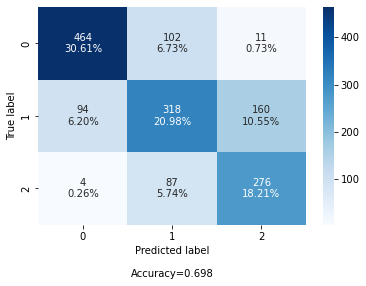

In [87]:
analysis_no_pred_prob(subsets['balanced'], target_names, rocchio_best)

c:\Users\jjbocek\anaconda3\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:164: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(


              precision    recall  f1-score   support

   non-toxic       0.70      0.70      0.70       577
       toxic       0.55      0.32      0.40       572
severe_toxic       0.47      0.77      0.58       367

    accuracy                           0.57      1516
   macro avg       0.57      0.60      0.56      1516
weighted avg       0.59      0.57      0.56      1516



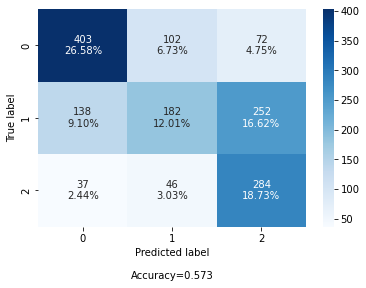

In [88]:
analysis_no_pred_prob(subsets['balanced_D2V'], target_names, doc2Vec_rocchio_best)

### KNN

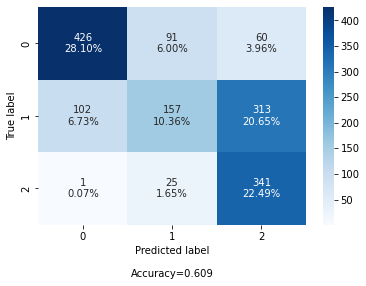

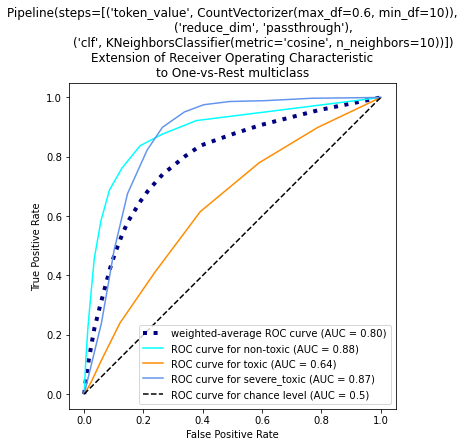

              precision    recall  f1-score   support

   non-toxic       0.81      0.74      0.77       577
       toxic       0.58      0.27      0.37       572
severe_toxic       0.48      0.93      0.63       367

    accuracy                           0.61      1516
   macro avg       0.62      0.65      0.59      1516
weighted avg       0.64      0.61      0.59      1516



In [89]:
analysis(subsets['balanced'], target_names, KNN_best, y_score1)

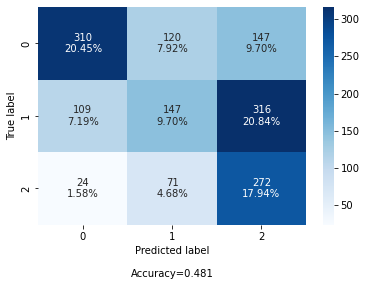

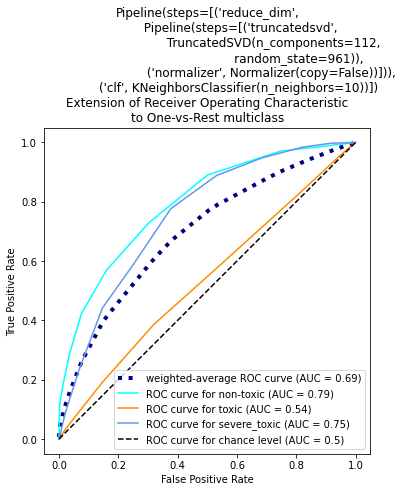

              precision    recall  f1-score   support

   non-toxic       0.70      0.54      0.61       577
       toxic       0.43      0.26      0.32       572
severe_toxic       0.37      0.74      0.49       367

    accuracy                           0.48      1516
   macro avg       0.50      0.51      0.47      1516
weighted avg       0.52      0.48      0.47      1516



In [90]:
analysis(subsets['balanced_D2V'], target_names, Doc2Vec_KNN_best, y_score1)

### Naive Bayes

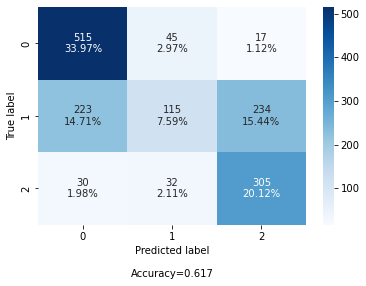

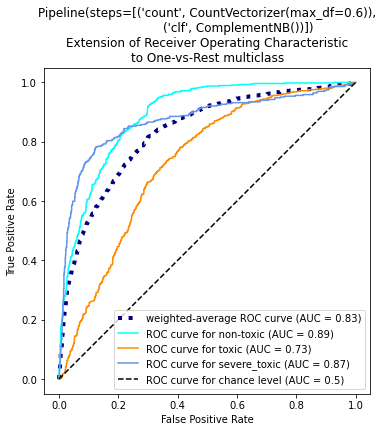

              precision    recall  f1-score   support

   non-toxic       0.67      0.89      0.77       577
       toxic       0.60      0.20      0.30       572
severe_toxic       0.55      0.83      0.66       367

    accuracy                           0.62      1516
   macro avg       0.61      0.64      0.58      1516
weighted avg       0.61      0.62      0.57      1516



In [91]:
analysis(subsets['balanced'], target_names, CV_NB_best, y_score1)

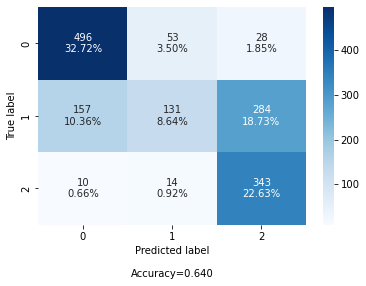

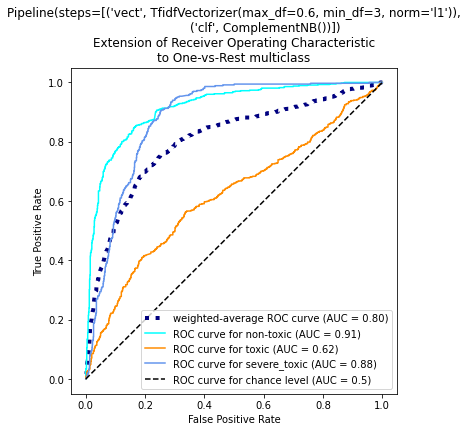

              precision    recall  f1-score   support

   non-toxic       0.75      0.86      0.80       577
       toxic       0.66      0.23      0.34       572
severe_toxic       0.52      0.93      0.67       367

    accuracy                           0.64      1516
   macro avg       0.64      0.67      0.60      1516
weighted avg       0.66      0.64      0.60      1516



In [92]:
analysis(subsets['balanced'], target_names, Tfidf_NB_best, y_score1)

### Model Evaluation Dataframe

In [93]:
score_df = pd.DataFrame(scores).set_index("Classifier/Pipeline")
score_df = score_df.round(2)
score_df

,Accuracy,ROC_AUC,Precision,Recall,F1
Classifier/Pipeline,,,,,
"(TfidfVectorizer(max_df=0.6, min_df=3), (TruncatedSVD(n_components=112, random_state=961), Normalizer(copy=False)), SGDClassifier(l1_ratio=0.9, loss='log', max_iter=8000, n_jobs=-1,\n penalty='elasticnet', random_state=961))",0.73,N/A,0.73,0.73,0.72
"((TruncatedSVD(n_components=112, random_state=961), Normalizer(copy=False)), SGDClassifier(l1_ratio=0.9, loss='log', max_iter=8000, n_jobs=-1,\n penalty='elasticnet', random_state=961))",0.64,N/A,0.64,0.64,0.64
"(TfidfVectorizer(max_df=0.6), passthrough, NearestCentroid(metric='cosine'))",0.70,N/A,0.70,0.70,0.70
"((TruncatedSVD(n_components=112, random_state=961), Normalizer(copy=False)), NearestCentroid(metric='cosine'))",0.57,N/A,0.59,0.57,0.56
"(CountVectorizer(max_df=0.6, min_df=10), passthrough, KNeighborsClassifier(metric='cosine', n_neighbors=10))",0.61,0.797721,0.64,0.61,0.59
"((TruncatedSVD(n_components=112, random_state=961), Normalizer(copy=False)), KNeighborsClassifier(n_neighbors=10))",0.48,0.695487,0.52,0.48,0.47
"(CountVectorizer(max_df=0.6), ComplementNB())",0.62,0.831068,0.61,0.62,0.57
"(TfidfVectorizer(max_df=0.6, min_df=3, norm='l1'), ComplementNB())",0.64,0.806341,0.66,0.64,0.60


In comparing our different tuned models we found the following three the best:  
* Stochastic Gradient Descent Logistic Regression using the Tfidf matrix and normalized truncated Singular Value Decomposition.
* Rocchio (Nearest Centroid) using the Tfidf matrix.
* Compliment Naive Bayes  using the Tfidf matrix.  

We made this determination primarily on the F1 score. The F1 score represents precision and recall in one metric. We are interested in classifying our comments as non-toxic, toxic, or severely toxic. Most importantly we want to minimize our False Negative rate. If a comment is toxic, we do not want to label it as non-toxic and thus not be flagged or removed by the application. Hence, we paid special attention to the recall score which focuses on the false negatives. Looking at the confusion matrices below, we see the most errors in trying to classify the toxic comments (label “1”). If we had to choose the best model, we would use Gradient Descent Logistic Regression because it has the lowest instances of classifying toxic and severely toxic comments as non toxic (5.8% and 0.26% respectively).


### Models Tested on Unbalanced Data

In [94]:
#reset scores dataframe
scores = defaultdict(list)

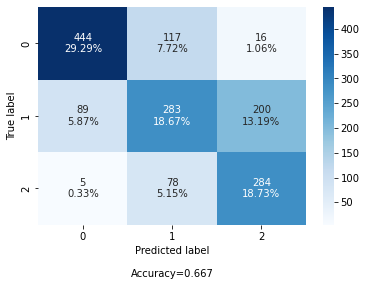

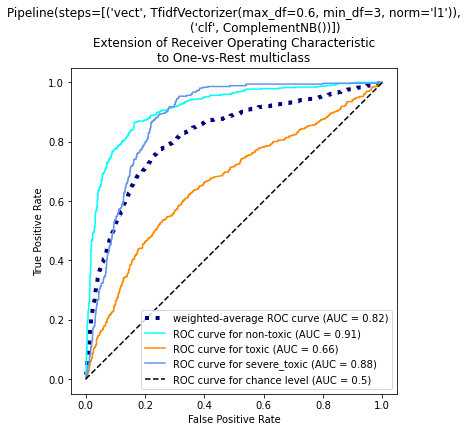

              precision    recall  f1-score   support

   non-toxic       0.83      0.77      0.80       577
       toxic       0.59      0.49      0.54       572
severe_toxic       0.57      0.77      0.66       367

    accuracy                           0.67      1516
   macro avg       0.66      0.68      0.66      1516
weighted avg       0.67      0.67      0.67      1516



In [95]:
#Compliment Naive Bayes with unbalanced test data
analysis(subsets['unbalanced'], target_names, Tfidf_NB_best, y_score1)

c:\Users\jjbocek\anaconda3\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:164: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(


              precision    recall  f1-score   support

   non-toxic       0.84      0.81      0.83       577
       toxic       0.65      0.58      0.61       572
severe_toxic       0.63      0.77      0.69       367

    accuracy                           0.71      1516
   macro avg       0.71      0.72      0.71      1516
weighted avg       0.72      0.71      0.71      1516



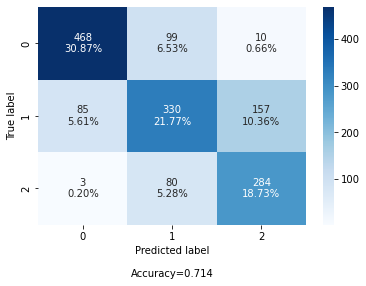

In [96]:
#Gradient Descent Logistic Regression with unbalanced test data
analysis_no_pred_prob(subsets['unbalanced'], target_names, rocchio_best)

              precision    recall  f1-score   support

   non-toxic       0.93      0.67      0.77       577
       toxic       0.61      0.77      0.68       572
severe_toxic       0.72      0.74      0.73       367

    accuracy                           0.72      1516
   macro avg       0.75      0.72      0.73      1516
weighted avg       0.76      0.72      0.73      1516



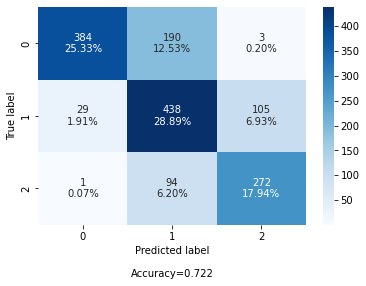

In [97]:
#Rocchio with unbalanced test data
analysis_no_pred_prob(subsets['unbalanced'], target_names, Logistic_best)

In [98]:
score_df = pd.DataFrame(scores).set_index("Classifier/Pipeline")
score_df = score_df.round(2)
score_df

,Accuracy,ROC_AUC,Precision,Recall,F1
Classifier/Pipeline,,,,,
"(TfidfVectorizer(max_df=0.6, min_df=3, norm='l1'), ComplementNB())",0.67,0.817975,0.67,0.67,0.67
"(TfidfVectorizer(max_df=0.6), passthrough, NearestCentroid(metric='cosine'))",0.71,N/A,0.72,0.71,0.71
"(TfidfVectorizer(max_df=0.6, min_df=3), (TruncatedSVD(n_components=112, random_state=961), Normalizer(copy=False)), SGDClassifier(l1_ratio=0.9, loss='log', max_iter=8000, n_jobs=-1,\n penalty='elasticnet', random_state=961))",0.72,N/A,0.76,0.72,0.73


To further evaluate the best three models we test the models using unbalanced test data. The original test data had instances of non-toxic (577), toxic (572), and severely toxic (367). For using unbalanced test data we doubled the toxic instances to 1,144. From the confusion the analysis results we see that the Complement Naive Bayes model improved performance on this test data. This may have occurred by giving increased instances to toxic so the model could differentiate them better. The toxic class is where all of our models struggled to predict. 

### Top 3 Models with Unbalanced Dataset using Ensemble

In an attempt to improve our models we created a simple ensemble model which combined these three best models by a “hard” vote, or a simple majority vote between the models. 

In [99]:
estimators = {
    ('NaiveBayes', Tfidf_NB_best),
    ('SGD_Logistic', Logistic_best),
    ('Rocchio', rocchio_best)
}

#create the ensemble classifier
ensemble = VotingClassifier(estimators, voting = 'hard')

#fit the model to the training data
#ensemble.fit(subsets['unbalanced'][0], subsets['unbalanced'][1])

#test the model
#ensemble.score(subsets['unbalanced'][2], subsets['unbalanced'][3])

c:\Users\jjbocek\anaconda3\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:164: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(


              precision    recall  f1-score   support

   non-toxic       0.86      0.77      0.81       577
       toxic       0.64      0.64      0.64       572
severe_toxic       0.66      0.78      0.72       367

    accuracy                           0.72      1516
   macro avg       0.72      0.73      0.72      1516
weighted avg       0.73      0.72      0.72      1516



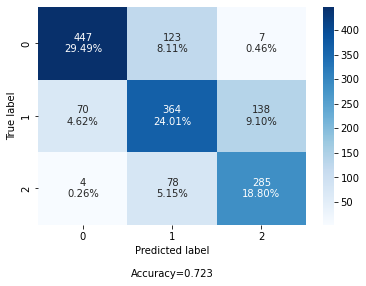

In [100]:
analysis_no_pred_prob(subsets['unbalanced'], target_names, ensemble)